# 18. Heuristic decision-making

* 싸이그래머 / 인지모델링 - 베이지안 인지 모델링 [1]
* 김무성

# Contents
* 18.1 Take-the-best
* 18.2 Stopping
* 18.3 Searching
* 18.4 Searching and stopping

# 18.1 Take-the-best

#### 참고
* [4] Gigerenzer - http://www.slideshare.net/guest27d3a1/gigerenzer

<img src="figures/cap18.1.png" width=600 />

#### The script TTB.txt implements the graphical model in WinBUGS:

In [ ]:
# Take The Best
model{
  # Data
  for (q in 1:nq){
    for (i in 1:ns){
      y[i,q] ~ dbern(ttb[t[q]])
      ypred[i,q] ~ dbern(ttb[t[q]])
} }
  # TTB Model For Each Question
  for (q in 1:nq){
    # Add Cue Contributions To Mimic TTB Decision
      for (j in 1:nc){
      tmp1[q,j] <- (m[p[q,1],j]-m[p[q,2],j])*pow(2,s[j]-1)
    }
    # Find if Cue Favors First, Second, or Neither Stimulus
    tmp2[q] <- sum(tmp1[q,1:nc])
    tmp3[q] <- -1*step(-tmp2[q])+step(tmp2[q])
    t[q] <- tmp3[q]+2
  }
  # Cue Search Order Follows Validities
  for (j in 1:nc){
    s[j] <- rank(v[1:nc],j)
  }
  # Choose TTB Decision With Probability Gamma, or Guess
  ttb[1] <- 1-gamma
  ttb[2] <- 0.5
  ttb[3] <- gamma
# Priors
  gamma ~ dunif(0.5,1)
}

<img src="figures/cap18.2.png" width=600 />

<img src="figures/cap18.3.png" width=600 />

### Stan code

#### TTB_Stan.R

In [2]:
library(rstan)

Loading required package: Rcpp
Loading required package: inline

Attaching package: ‘inline’

The following object is masked from ‘package:Rcpp’:

    registerPlugin

rstan (Version 2.6.0, packaged: 2015-02-06 21:02:34 UTC, GitRev: 198082f07a60)


In [3]:
model <- "
// Take The Best

data {
  int ns;
  int nq;
  int nc;
  int y[ns,nq];
  int m[83,nc];
  int p[nq,2];
  vector[nc] v;
}

transformed data {
  int<lower=1,upper=nc> s[nc];
  int<lower=0,upper=3> t[nq];
  
  // Cue Search Order Follows Validities
  s <- sort_indices_asc(v);
  
  // TTB Model For Each Question
  for (q in 1:nq) {	
    vector[nc] tmp1;
    real tmp2;
    int tmp3;

    // Add Cue Contributions To Mimic TTB Decision
    for (j in 1:nc)
      tmp1[j] <- (m[p[q,1],j] - m[p[q,2],j]) * 2 ^ (s[j] - 1);
      
    // Find if Cue Favors First, Second, or Neither Stimulus
    tmp2 <- sum(tmp1);
    tmp3 <- -1 * int_step(-tmp2) + int_step(tmp2);
    t[q] <- tmp3 + 2;
  }
}

parameters {
  real<lower=.5,upper=1> gamma;
}

transformed parameters {
  vector<lower=0,upper=1>[3] ttb;

  // Choose TTB Decision With Probability Gamma, or Guess
  ttb[1] <- 1 - gamma;
  ttb[2] <- .5;
  ttb[3] <- gamma;
} 

model {
  // Data
  for (q in 1:nq)
    for (i in 1:ns)
      y[i,q] ~ bernoulli(ttb[t[q]]);
}

generated quantities {
  int<lower=0,upper=1> ypred[ns,nq];

  for (q in 1:nq)
    for (i in 1:ns)
      ypred[i,q] <- bernoulli_rng(ttb[t[q]]);
}"

In [4]:
load("StopSearchData.RData")  # Load all data for the model

In [18]:
data <- list(nc=nc, nq=nq, ns=ns, v=v, p=p, m=m, y=y) # To be passed on to Stan

In [7]:
nc

[1] 9

In [8]:
nq

[1] 30

In [9]:
ns

[1] 20

In [10]:
v

[1] 1.0000 0.9643 0.9118 0.9000 0.8000 0.7843 0.6923 0.6538 0.5588

In [14]:
head(p)

[,1] [,2]
[1,]   65   44
[2,]   83   44
[3,]   46   65
[4,]   46   70
[5,]   47   57
[6,]   47   67

In [13]:
head(m)

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9]
[1,]    1    1    0    1    1    1    1    0    0
[2,]    0    1    1    0    1    1    1    0    0
[3,]    0    1    1    1    1    1    1    0    0
[4,]    0    1    1    1    1    1    0    0    0
[5,]    0    1    1    1    1    1    0    0    0
[6,]    0    1    0    1    1    1    0    0    1

In [17]:
head(y)

[,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11] [,12] [,13] [,14]
[1,]    1    1    1    1    0    1    0    0    1     1     1     1     1     0
[2,]    1    1    1    1    1    1    1    1    1     1     1     1     1     1
[3,]    1    1    1    1    1    1    1    1    1     1     1     1     1     1
[4,]    1    1    0    1    1    1    1    1    0     1     1     1     1     1
[5,]    0    1    0    1    1    0    1    1    1     1     1     1     1     0
[6,]    1    1    1    1    1    0    1    1    1     1     1     1     1     1
     [,15] [,16] [,17] [,18] [,19] [,20] [,21] [,22] [,23] [,24] [,25] [,26]
[1,]     1     1     1     1     1     1     1     1     1     1     0     0
[2,]     1     1     1     1     1     1     1     1     1     0     1     1
[3,]     1     1     1     1     1     1     1     1     1     1     1     0
[4,]     0     1     0     0     1     1     0     1     1     1     0     1
[5,]     0     1     0     0     0     1     1     0     1     0     1     0
[6,]     1     1     0     1     1     1     1     1     1     1     0     1
     [,27] [,28] [,29] [,30]
[1,]     0     0     0     0
[2,]     0     1     1     0
[3,]     0     0     1     0
[4,]     0     1     1     1
[5,]     1     0     0     0
[6,]     1     1     0     0

In [19]:
myinits <- list(
  list(gamma=.75))

parameters <- c("gamma", "ypred")  # Parameters to be monitored

In [20]:
# For a detailed description type "?stan".
samples <- stan(model_code=model,   
                data=data, 
                init=myinits,  # If not specified, gives random inits
                pars=parameters,
                iter=5500, 
                chains=1, 
                thin=1,
                warmup=500,  # Stands for burn-in; Default = iter/2
                # seed=123  # Setting seed; Default is random seed
)


TRANSLATING MODEL 'model' FROM Stan CODE TO C++ CODE NOW.
COMPILING THE C++ CODE FOR MODEL 'model' NOW.
In file included from filef640361d1cb9.cpp:8:
In file included from /Library/Frameworks/R.framework/Versions/3.2/Resources/library/rstan/include//stansrc/stan/model/model_header.hpp:17:
In file included from /Library/Frameworks/R.framework/Versions/3.2/Resources/library/rstan/include//stansrc/stan/agrad/rev.hpp:5:
/Library/Frameworks/R.framework/Versions/3.2/Resources/library/rstan/include//stansrc/stan/agrad/rev/chainable.hpp:87:17: warning: 'static' function 'set_zero_all_adjoints' declared in header file should be declared 'static inline' [-Wunneeded-internal-declaration]
    static void set_zero_all_adjoints() {
                ^
In file included from filef640361d1cb9.cpp:8:
In file included from /Library/Frameworks/R.framework/Versions/3.2/Resources/library/rstan/include//stansrc/stan/model/model_header.hpp:21:
/Library/Frameworks/R.framework/Versions/3.2/Resources/library/rsta

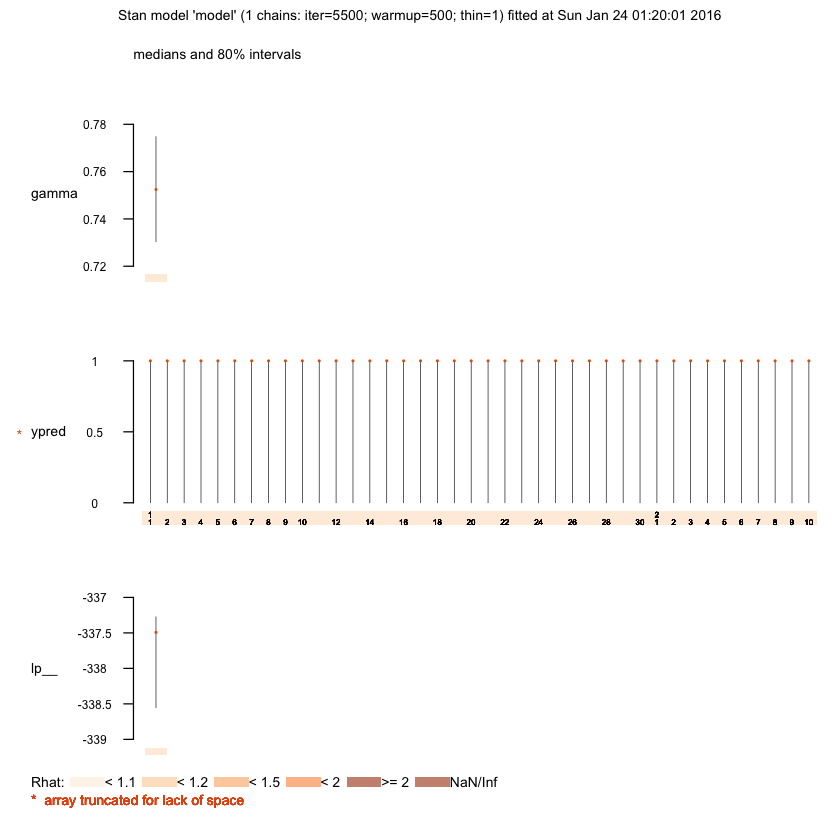

In [25]:
plot(samples)

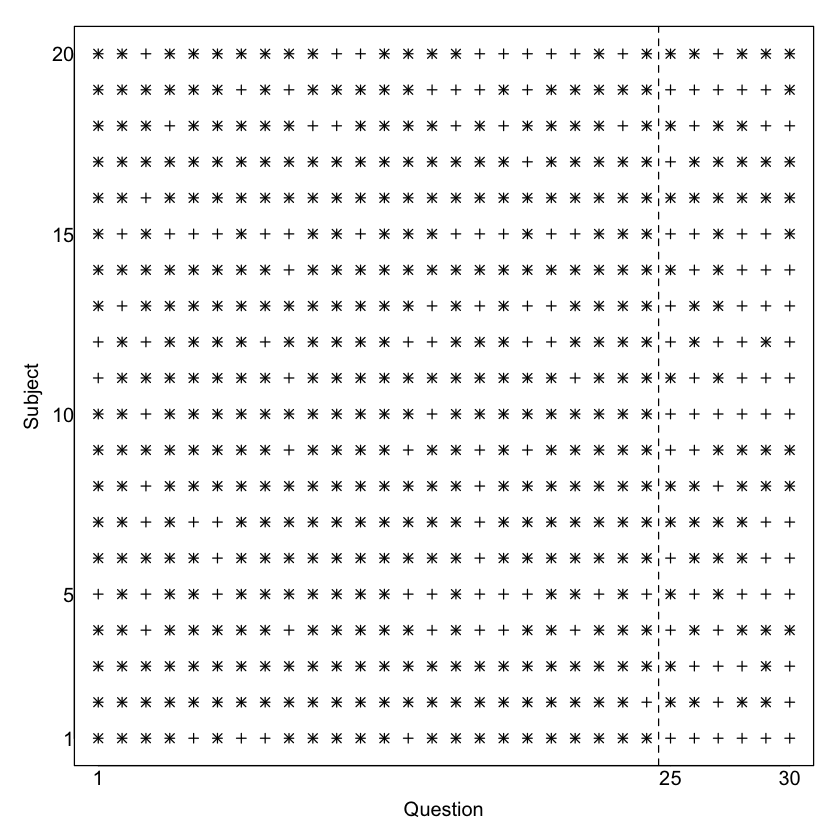

In [24]:
# Now the values for the monitored parameters are in the "samples" object, 
# ready for inspection.

#### Figure 18.2 ####
means <- get_posterior_mean(samples)

get_mean <- function(i, j) {
  means[paste("ypred[", i, ",", j, "]", sep=""), ]
}

#figure(9,5)
par(mar=c(3, 3, 1, 1) + .1, xaxs="i", mgp=c(1.3, 0, 0))
plot("", xlim=c(0, 31), ylim=c(1, 20), xlab="Question", ylab="Subject", xaxt="n", yaxt="n")
axis(1, c(1, 25, 30), tck=0)
axis(2, c(1, 5, 10, 15, 20), tck=0, las=2)
abline(v=24.5, lty=2)


for (i in 1:ns) {
  for (j in 1:nq) {
    points(j, i, pch=3, cex=get_mean(i, j))
    points(j, i, pch=4, cex=y[i, j])
  }
}

# 18.2 Stopping

<img src="figures/cap18.4.png" width=600 />

<img src="figures/cap18.5.png" width=600 />

<img src="figures/cap18.6.png" width=600 />

<img src="figures/cap18.7.png" width=600 />

### Stan code

#### Stop_Stan.R

In [31]:
library(rstan)

In [32]:
model <- "
// Stop
data {
  int ns;
  int nq;
  int nc;
  int y[ns,nq];
  int m[83,nc];
  int p[nq,2];
  vector[nc] v;
  vector[nc] x;
}
transformed data {
  int<lower=1,upper=nc> s[nc];
  int<lower=0,upper=3> t[ns,nq,2];
  
  // Cue Search Order Follows Validities
  s <- sort_indices_asc(v);
  
  // TTB Decision
  for (i in 1:ns) {  
    for (q in 1:nq) {	
      vector[nc] tmp1;
      real tmp2;
      int tmp3;

      // Add Cue Contributions To Mimic TTB Decision
      for (j in 1:nc)
        tmp1[j] <- (m[p[q,1],j] - m[p[q,2],j]) * 2 ^ (s[j] - 1);
        
      // Find if Cue Favors First, Second, or Neither Stimulus
      tmp2 <- sum(tmp1);
      tmp3 <- -1 * int_step(-tmp2) + int_step(tmp2);
      t[i,q,1] <- tmp3 + 2;
    }
  }
  // WADD Decision
  for (i in 1:ns) {
    for (q in 1:nq) {
      vector[nc] tmp4;
      real tmp5;
      int tmp6;
      
      for (j in 1:nc)
        tmp4[j] <- (m[p[q,1],j] - m[p[q,2],j]) * x[j];
      
      // Find if Cue Favors First, Second, or Neither Stimulus
      tmp5 <- sum(tmp4);
      tmp6 <- -1 * int_step(-tmp5) + int_step(tmp5);
      t[i,q,2] <- tmp6 + 2;
    }
  }
}
parameters {
  real<lower=.5,upper=1> gamma;
  real<lower=0,upper=1> phi;
}
transformed parameters {
  vector<lower=0,upper=1>[3] dec;
  vector[2] lp_parts[ns];

  // Follow Decision With Probability Gamma, or Guess
  dec[1] <- 1 - gamma;
  dec[2] <- .5;
  dec[3] <- gamma;
  
  // TTB and WADD Subjects in Latent Mixture
  for (i in 1:ns) {
    vector[nq] lp_tmp1;
    vector[nq] lp_tmp2;
    for (q in 1:nq) {
      lp_tmp1[q] <- bernoulli_log(y[i,q], dec[t[i,q,1]]);
      lp_tmp2[q] <- bernoulli_log(y[i,q], dec[t[i,q,2]]);
    }
    lp_parts[i,1] <- log1m(phi) + sum(lp_tmp1);
    lp_parts[i,2] <- log(phi) + sum(lp_tmp2);
  }
} 
model {
  // Prior
  phi ~ beta(1, 1);
  
  for (i in 1:ns)
    increment_log_prob(log_sum_exp(lp_parts[i]));
}
generated quantities {
  int<lower=0,upper=1> ypred[ns,nq];
  int<lower=0,upper=1> z[ns];

  for (i in 1:ns) {
    vector[2] prob;    
    prob <- softmax(lp_parts[i]);
    z[i] <- bernoulli_rng(prob[2]);
  }
  for (q in 1:nq)
    for (i in 1:ns)
      ypred[i,q] <- bernoulli_rng(dec[t[i,q,(z[i] + 1)]]);
}"

In [33]:
load("StopSearchData.RData")  # Load all data for the model

In [34]:
# To be passed on to Stan
data <- list(nc=nc, nq=nq, ns=ns, v=v, p=p, m=m, y=y, x=x) 

myinits <- list(
  list(gamma=.75, phi=.5))

parameters <- c("gamma", "ypred", "z", "phi")  # Parameters to be monitored


In [35]:
# For a detailed description type "?stan".
samples <- stan(model_code=model,   
                data=data, 
                init=myinits,  # If not specified, gives random inits
                pars=parameters,
                iter=3500, 
                chains=1, 
                thin=1,
                warmup=500,  # Stands for burn-in; Default = iter/2
                # seed=123  # Setting seed; Default is random seed
)
# Now the values for the monitored parameters are in the "samples" object, 
# ready for inspection.


TRANSLATING MODEL 'model' FROM Stan CODE TO C++ CODE NOW.
COMPILING THE C++ CODE FOR MODEL 'model' NOW.
In file included from filef640345e0943.cpp:8:
In file included from /Library/Frameworks/R.framework/Versions/3.2/Resources/library/rstan/include//stansrc/stan/model/model_header.hpp:17:
In file included from /Library/Frameworks/R.framework/Versions/3.2/Resources/library/rstan/include//stansrc/stan/agrad/rev.hpp:5:
/Library/Frameworks/R.framework/Versions/3.2/Resources/library/rstan/include//stansrc/stan/agrad/rev/chainable.hpp:87:17: warning: 'static' function 'set_zero_all_adjoints' declared in header file should be declared 'static inline' [-Wunneeded-internal-declaration]
    static void set_zero_all_adjoints() {
                ^
In file included from filef640345e0943.cpp:8:
In file included from /Library/Frameworks/R.framework/Versions/3.2/Resources/library/rstan/include//stansrc/stan/model/model_header.hpp:21:
/Library/Frameworks/R.framework/Versions/3.2/Resources/library/rsta

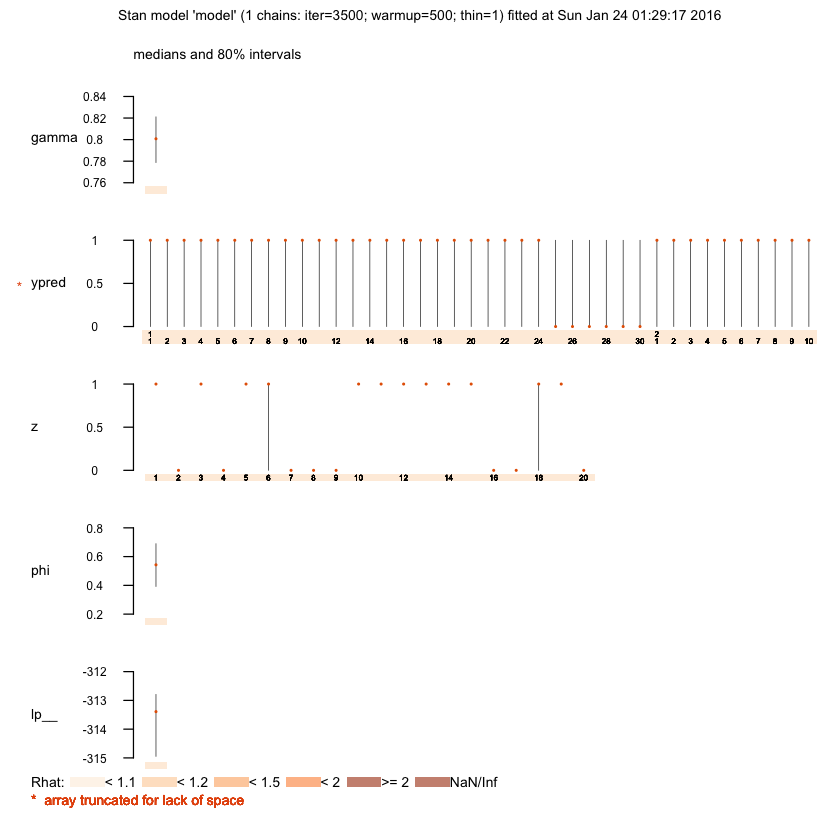

In [36]:
plot(samples)

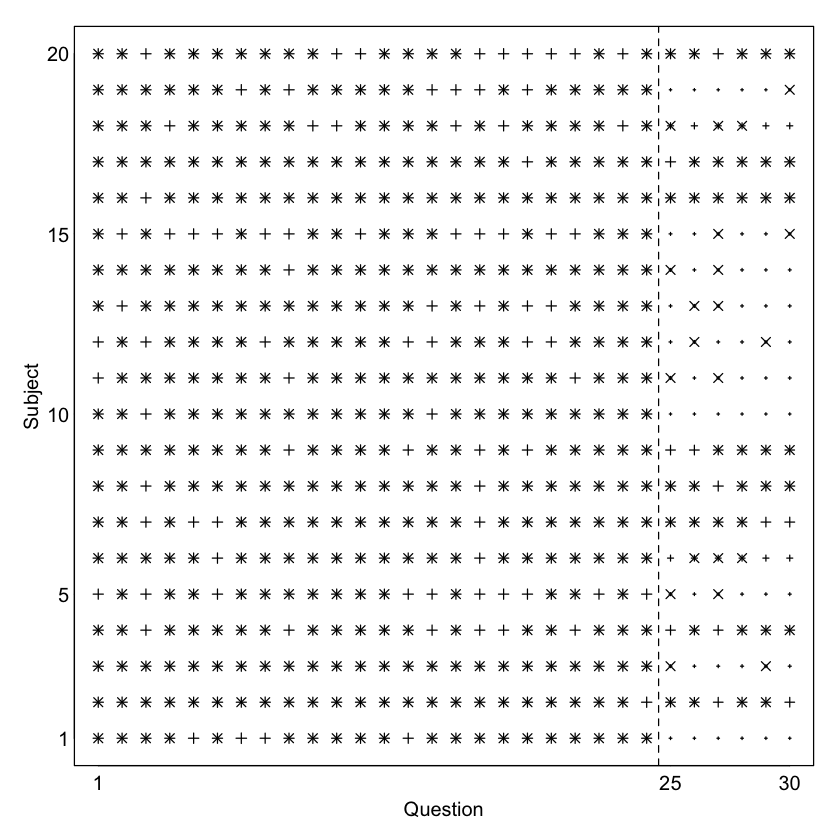

In [37]:
#### Figure 18.4 ####
means <- get_posterior_mean(samples)

get_mean <- function(var, i, j="", dim=2) {
  if (dim == 2)
    means[paste(var, "[", i, ",", j, "]", sep=""), ]
  else
    means[paste(var, "[", i, "]", sep=""), ]
}

#windows(9, 5)
par(mar=c(3, 3, 1, 1) + .1, xaxs="i", mgp=c(1.3, 0.2, 0))
plot("", xlim=c(0, 31), ylim=c(1, 20), xlab="Question", ylab="Subject", xaxt="n", yaxt="n")
axis(1, c(1, 25, 30), tck=0)
axis(2, c(1, 5, 10, 15, 20), tck=0, las=2)
abline(v=24.5, lty=2)

for (i in 1:ns) {
  for (j in 1:nq) {
    points(j, i, pch=3, cex=get_mean("ypred", i, j))
    points(j, i, pch=4, cex=y[i, j])
  }
}


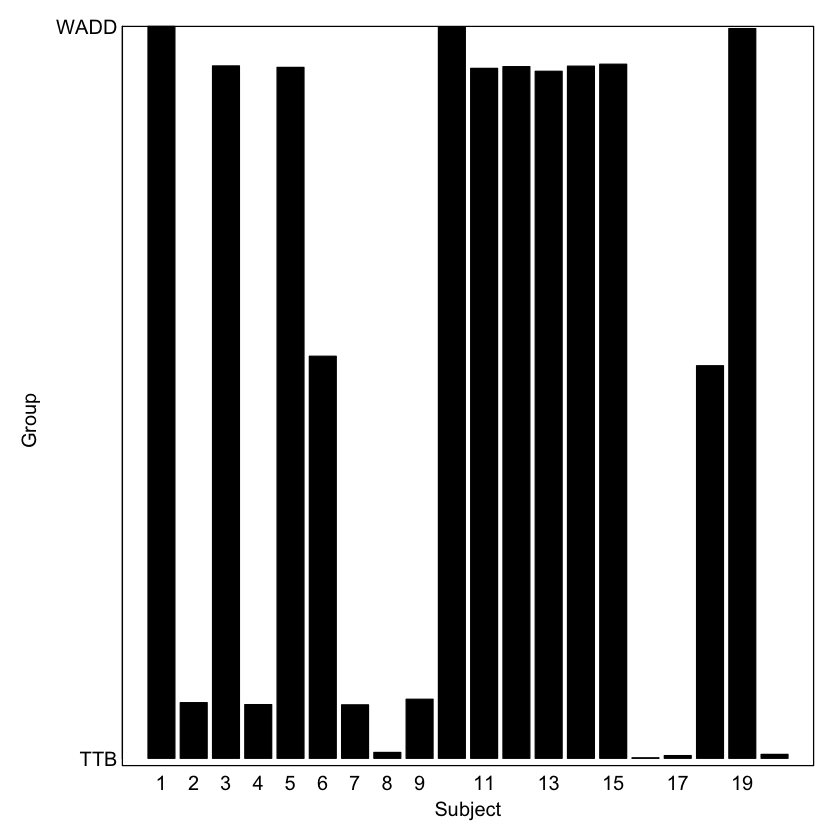

In [38]:
#### Figure 18.5 ####
#windows(8, 3)
par(mar=c(3, 2, 1, 1) + .1, mgp=c(1.3, 0.2, 0), oma=c(0,3,0,0))
barplot(get_mean("z", 1:20, dim=1), col="black", names.arg=1:20,
        yaxt="n", xlab="Subject", ylab="")
box()
title(ylab="Group", outer=T)
axis(2, at=c(0, 1), labels=c("TTB", "WADD"), tck=0, las=2)

# 18.3 Searching

<img src="figures/cap18.8.png" width=600 />

<img src="figures/cap18.9.png" width=600 />

# 18.4 Searching and stopping

<img src="figures/cap18.10.png" width=600 />

<img src="figures/cap18.11.png" width=600 />

# 참고자료
* [1] Bayesian Cognitive Modeling: A Practical Course - http://www.amazon.com/Bayesian-Cognitive-Modeling-Practical-Course/dp/1107603579/
* [2] codes(winbugs, jags) - http://bayesmodels.com/
* [3] codes(stan) - https://github.com/stan-dev/example-models/tree/master/Bayesian_Cognitive_Modeling
* [4] Gigerenzer - http://www.slideshare.net/guest27d3a1/gigerenzer
* [5] Take-the-best heuristic - https://en.wikipedia.org/wiki/Take-the-best_heuristic
* [6] Take The Best can emerge from Approximate Bayesian Computation - https://notsoirrational.files.wordpress.com/2016/01/ttbabctalk.pdf